In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [3]:
preprocess = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]),
                            transforms.Lambda(lambda t: t.unsqueeze(0))
                            ])

In [4]:
cnn = torchvision.models.resnet18(pretrained=True)

In [5]:
class Hook:
    
    def __init__(self, name, layer, backward=False):
        
        self.name = name
        
        if backward:
            #print('backward pass')
            layer.register_backward_hook(self.hook_fn)
        else:
            layer.register_forward_hook(self.hook_fn)
            
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
        self.module = module
        #print('hook executed')

In [6]:
hooks = []
conv = [None, None]
def recursive_hook(module, hooks, depth):
    for name, layer in module.named_children():
        #print('\t'*depth,f'Going in {name}')
        #print('\t'*depth,name)
        if name == 'layer4':
            hooks.append(Hook(name, layer))
            hooks.append(Hook(name, layer, True))
            #print('\t'*depth, f'{name} layer hooked')
        recursive_hook(layer, hooks, depth+1)

def last_conv(module, conv, depth):
    for name, layer in module.named_children():
        if isinstance(layer, nn.Conv2d):
            conv[0] = name
            conv[1] = layer
            #print('\t'*depth, f'{name} layer found')
        last_conv(layer, conv, depth+1)

In [7]:
last_conv(cnn, conv, 0)

In [8]:
hooks.append(Hook(conv[0], conv[1]))

In [9]:
with open('../test/imagenet_classes.txt') as f:
    lines = f.readlines()
lines = map(lambda line: line[1:].replace('\n', '').split(':'), lines)
classes = {int(line[0].replace("'", '')):line[1].replace("'", '') for line in lines}

In [44]:
image = Image.open('../test/cat_dog.png').convert('RGB')
img = preprocess(image)

In [45]:
cnn.eval()
def prediction(model, img, index):
    pred = cnn(img)
    return pred[0, index].item()
#prediction(cnn, img, 242)

In [54]:
pred = cnn(img)
class_index = pred.argmax().item()
class_index = 281
print(class_index, classes[class_index])

281  tabby, tabby cat,


In [55]:
scores = []
relu = nn.ReLU()
cam = hooks[0].output.data
for index in tqdm(range(cam.shape[1])):
    f_map = cam[:, index, :, :].unsqueeze(1)
    f_map = nn.functional.interpolate(f_map, scale_factor=img.shape[2]//f_map.shape[2], mode='bilinear', align_corners=False)
    f_map -= f_map.min()
    f_map /= f_map.max()
    if index == 0:
        M = img*f_map
    else:
        M = torch.cat((M, img*f_map))

100%|██████████| 512/512 [00:26<00:00, 19.56it/s]


In [66]:
bs = 64
with torch.no_grad():
    for i in range(M.shape[0]//bs):
        if i == 0:
            scores = cnn(M[bs*i:bs*(i+1),:,:,:])
        else:
            scores = torch.cat((scores, cnn(M[bs*i:bs*(i+1),:,:,:])))
        print(bs*i, bs*(i+1), scores.shape)


0 64 torch.Size([64, 1000])
64 128 torch.Size([128, 1000])
128 192 torch.Size([192, 1000])
192 256 torch.Size([256, 1000])
256 320 torch.Size([320, 1000])
320 384 torch.Size([384, 1000])
384 448 torch.Size([448, 1000])
448 512 torch.Size([512, 1000])


In [79]:
softmax = nn.Softmax()
tscores = scores
tscores = torch.tensor([i - pred[0, class_index].item() for i in tscores[:, 200]])
tscores = softmax(tscores)
tscores = tscores.view(1, -1, 1, 1)

<ipython-input-79-bff16767ce93>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tscores = softmax(tscores)


In [80]:
relu = nn.ReLU()
pred = cnn(img)
cam = hooks[0].output.data
print(cam.shape)
out = (relu(cam * tscores)).sum(1, keepdim=True)
print(out.shape)
out = nn.functional.interpolate(out, scale_factor=img.shape[2] // out.shape[2], mode='bilinear', align_corners=False)
print(out.shape)
out = out.squeeze(0).squeeze(0)
print(out.shape)

torch.Size([1, 512, 7, 7])
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([224, 224])


In [81]:
out -= out.min()
out /= out.max()

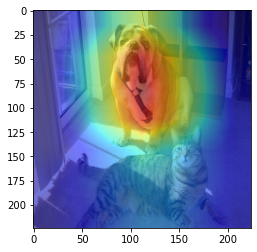

In [82]:
plt.imshow(out.numpy(), cmap='jet')
test_img = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow((test_img - np.min(test_img)) / (np.max(test_img) - np.min(test_img)), alpha=0.5)

out